### Generate training and testing sets

In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as linear
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import root_mean_squared_error as rmse
from math import e
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

In [2]:
# mostly taken from the book with some fixes (originally showed the square root of the RMSE instead of the RMSE)
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

def plot_learning_curves(model, X, y):
    x_train = X[:400]
    x_test = X[400:]

    y_train = y[:400]
    y_test = y[400:]

    #x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(x_train) + 1):
        model.fit(x_train[:m], y_train[:m])
        y_train_predict = model.predict(x_train[:m])
        y_val_predict = model.predict(x_test)
        train_errors.append(rmse(y_train[:m], y_train_predict))
        val_errors.append(rmse(y_test, y_val_predict))
    plt.plot(train_errors, "r-+", linewidth=2, label="train")
    plt.plot(val_errors, "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   
    plt.xlabel("Training set size", fontsize=14) 
    plt.ylabel("RMSE", fontsize=14)              
    plt.show()
    plt.clf()

In [3]:
# from the book, modified slightly
def plot_model(x, y_true, y_pred):
    plt.plot(x, y_true, "b.")
    plt.plot(x, y_pred, "r.", label="Predictions") # for whatever reason this was misbehaving when set to plot a line instead of points
    plt.xlabel("$x_1$", fontsize=18)
    plt.ylabel("$y$", rotation=0, fontsize=18)
    plt.legend(loc="upper left", fontsize=14)
    plt.axis([-10, 10, -1, 2])
    plt.show()
    plt.clf()

Defining x and y

In [4]:
np.random.seed(999)
x = 20 * np.random.rand(500, 1) - 10 # [-10, 10)
y_clean = 1 / (1+e**(-x))
y_noise = 1 / (1+e**(-x)) + np.random.normal(0, .38729)

Add noise to y

In [5]:
y = pd.DataFrame(y_clean, columns = ['clean']) # doing this in a DataFrame instead of directly in arrays because adding the noise wasn't working quite right with arrays
y['noise'] = y['clean'].apply(lambda x: x + np.random.normal(0, .38729))
y['diff'] = y['clean'] - y['noise']

In [6]:
y.head()

,clean,noise,diff
0,0.997691,0.998428,-0.000738
1,0.634239,0.927643,-0.293404
2,0.000491,0.117649,-0.117157
3,0.942331,0.381778,0.560552
4,0.000280,0.160097,-0.159817


The difference between the clean and noisy y has a mean of 0 and variance of .15

In [7]:
y['diff'].describe()

count    500.000000
mean      -0.007784
std        0.399933
min       -1.164406
25%       -0.262426
50%       -0.016436
75%        0.250864
max        1.213191
Name: diff, dtype: float64

In [8]:
y_noise = y['noise'].to_numpy() # convert from df back to array

Break up into training and testing sets (didn't bother with a random split since the data is generated randomly)

In [9]:
x_train = x[:400]
x_test = x[400:]

y_clean_train = y_clean[:400]
y_clean_test = y_clean[400:]

y_noise_train = y_noise[:400]
y_noise_test = y_noise[400:]


In [10]:
y_noise_test.shape

(100,)

In [11]:
y_noise_train.shape

(400,)

## Initial models

In [12]:
# fit the model with the given data, print the coefficient and intercept, find the RMSE on the train and validation data, and plot
def train_eval(model, x = x, y_clean = y_clean, y_noise = y_noise, x_plot = x_train):
    # break up the data into training and validation/testing
    x_train = x[:400]
    x_test = x[400:]

    y_clean_train = y_clean[:400]
    y_clean_test = y_clean[400:]

    y_noise_train = y_noise[:400]
    y_noise_test = y_noise[400:]

    # fit the clean model
    clean = model.fit(x_train, y_clean_train)
    try:# messy way of printing intercepts/coefficients for the linear models and not the SVR/RF 
        print(f'Clean model intercept: {clean.intercept_[0]}')
        print(f'Clean model coefficient: {clean.coef_}')
    except:
        pass

    # get predictions for the training and testing/validation data
    clean_train_predictions = clean.predict(x_train)
    clean_test_predictions = clean.predict(x_test)

    print(f'Clean model training RMSE: {rmse(clean_train_predictions, y_clean_train)}')
    print(f'Clean model testing RMSE: {rmse(clean_test_predictions, y_clean_test)}')

    # fit the noisy model
    noisy = model.fit(x_train, y_noise_train)
    try: 
        print(f'Noisy model intercept: {noisy.intercept_}')
        print(f'Noisy model coefficient: {noisy.coef_}')
    except:
        pass

    # get predictions for the training and testing/validation data
    noisy_train_predictions = noisy.predict(x_train)
    noisy_test_predictions = noisy.predict(x_test)

    print(f'Noisy model training RMSE: {rmse(noisy_train_predictions, y_noise_train)}')
    print(f'Noisy model testing RMSE: {rmse(noisy_test_predictions, y_noise_test)}')

    print("Clean model")
    plot_model(x_plot, y_clean_train, clean_train_predictions)

    print("Noisy model")
    plot_model(x_plot, y_noise_train, noisy_train_predictions)

Clean model intercept: 0.49541174039549657
Clean model coefficient: [[0.07168985]]
Clean model training RMSE: 0.1571030031186975
Clean model testing RMSE: 0.16793948494279742
Noisy model intercept: 0.5069556438783054
Noisy model coefficient: [0.07336211]
Noisy model training RMSE: 0.42243068977249526
Noisy model testing RMSE: 0.47743803250063177
Clean model


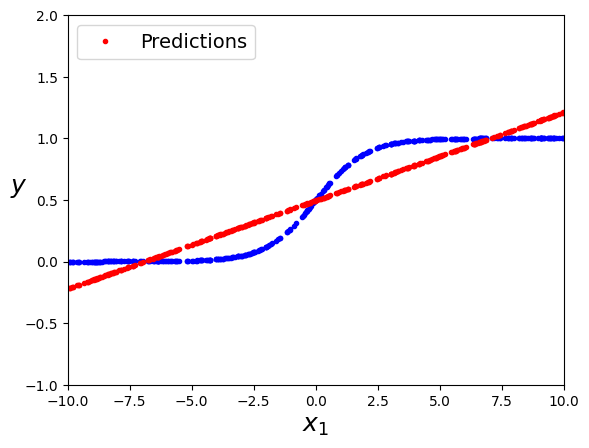

Noisy model


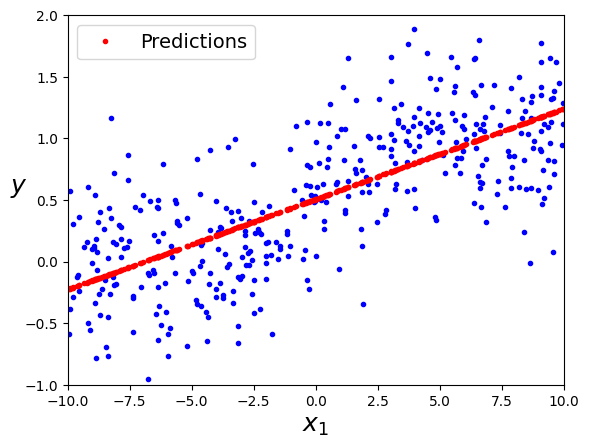

<Figure size 640x480 with 0 Axes>

In [13]:
ols = linear.LinearRegression()
train_eval(ols)

The model trained with noisy data performs much worse- much higher RMSE and a larger gap between training and validation scores

Polynomial regression, order 2

Number of polynomial features: 2
Clean model intercept: 0.4966940406630843
Clean model coefficient: [[ 7.16969087e-02 -3.69138984e-05]]
Clean model training RMSE: 0.15709901977625576
Clean model testing RMSE: 0.16793715391129818
Noisy model intercept: 0.5201410686652795
Noisy model coefficient: [ 0.07343466 -0.00037957]
Noisy model training RMSE: 0.4222740289198531
Noisy model testing RMSE: 0.47777826344270713
Clean model


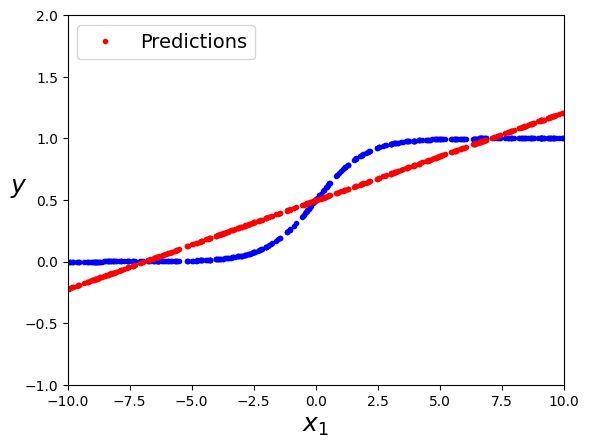

Noisy model


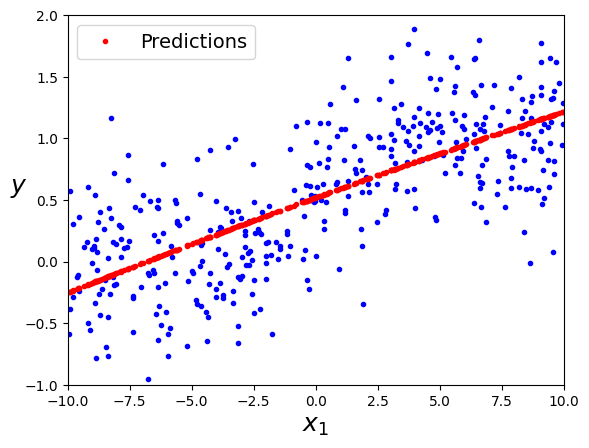

Number of polynomial features: 3
Clean model intercept: 0.4956756786732067
Clean model coefficient: [[ 1.26761339e-01  1.03387576e-04 -9.00063736e-04]]
Clean model training RMSE: 0.07438033094052163
Clean model testing RMSE: 0.08341891839162445
Noisy model intercept: 0.5191606662692874
Noisy model coefficient: [ 0.12644656 -0.0002445  -0.00086651]
Noisy model training RMSE: 0.4007100535169252
Noisy model testing RMSE: 0.442912945042308
Clean model


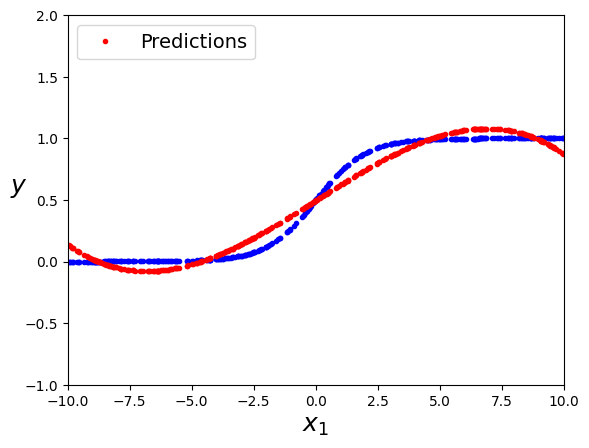

Noisy model


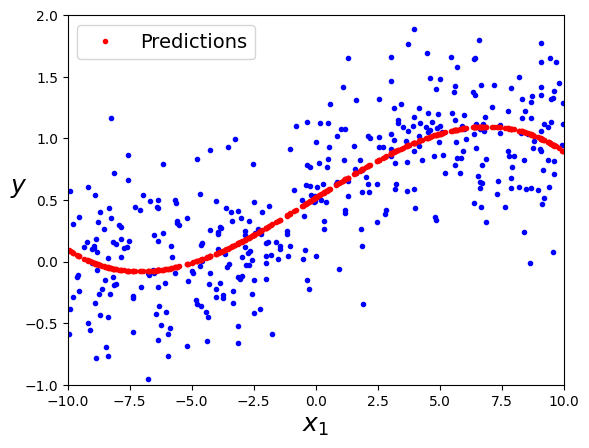

Number of polynomial features: 4
Clean model intercept: 0.49930212825740117
Clean model coefficient: [[ 1.26826823e-01 -2.49168876e-04 -9.01365330e-04  4.05769967e-06]]
Clean model training RMSE: 0.07431878403279338
Clean model testing RMSE: 0.0835578619418169
Noisy model intercept: 0.510510859932014
Noisy model coefficient: [ 1.26290365e-01  5.96417128e-04 -8.63409167e-04 -9.67842389e-06]
Noisy model training RMSE: 0.40064507959562645
Noisy model testing RMSE: 0.4435985317237225
Clean model


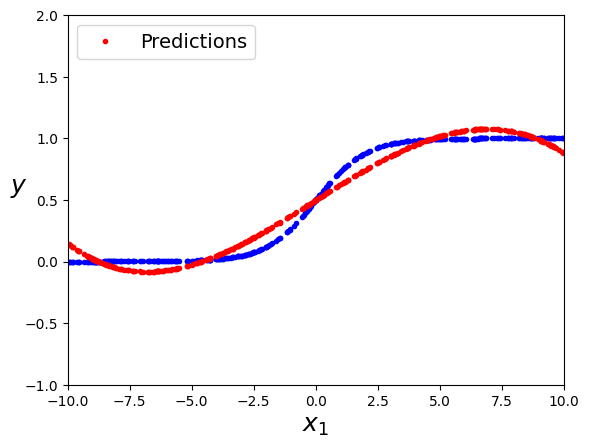

Noisy model


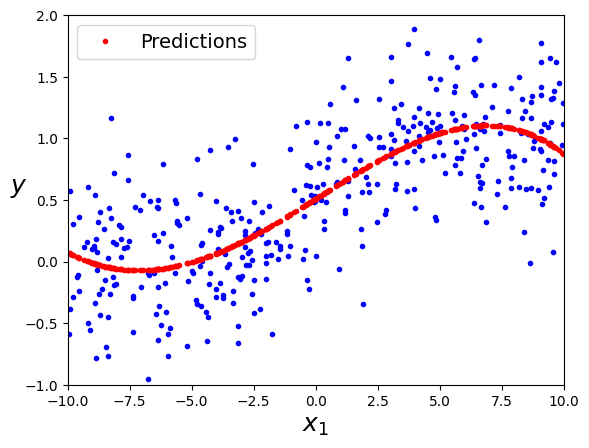

Number of polynomial features: 5
Clean model intercept: 0.501623417557895
Clean model coefficient: [[ 1.66099217e-01 -1.85317943e-04 -2.75888070e-03  1.76163381e-06
   1.68158646e-05]]
Clean model training RMSE: 0.038660725428129476
Clean model testing RMSE: 0.044288607790837105
Noisy model intercept: 0.5139822377940056
Noisy model coefficient: [ 1.85020364e-01  6.91903165e-04 -3.64123515e-03 -1.31120813e-05
  2.51473265e-05]
Noisy model training RMSE: 0.38923892377211056
Noisy model testing RMSE: 0.4291135891007198
Clean model


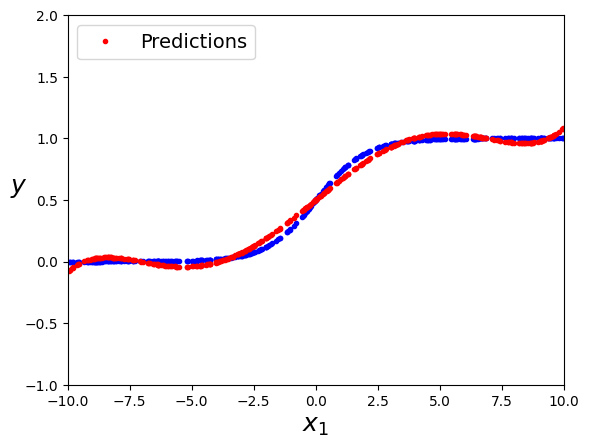

Noisy model


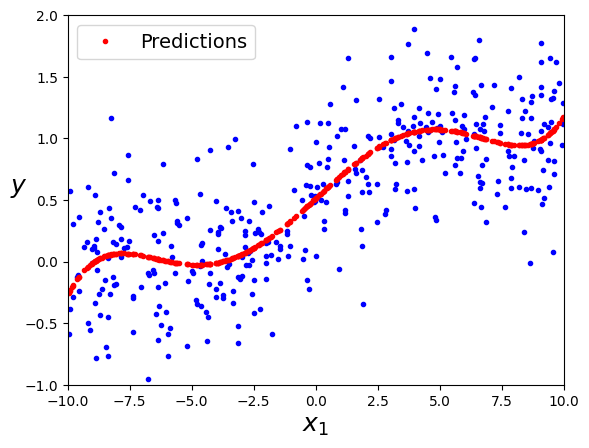

<Figure size 640x480 with 0 Axes>

In [14]:
for i in range(2, 6):
    print(f'Number of polynomial features: {i}')
    poly_features = PolynomialFeatures(degree = i, include_bias = False)
    x_poly = poly_features.fit_transform(x)
    train_eval(linear.LinearRegression(), x_poly)


Noisy models continue to perform much worse: more polynomial features aren't reducing the RMSE very much. On the other hand, the clean model is performing much better when it is allowed more features.

Let's use ridge regression to try to reduce the dependence on specific weights

Number of polynomial features: 2
Clean model intercept: 0.49669403226913766
Clean model coefficient: [ 7.16968570e-02 -3.69135244e-05]
Clean model training RMSE: 0.15709901977655047
Clean model testing RMSE: 0.16793720140917234
Noisy model intercept: 0.5201410597447462
Noisy model coefficient: [ 0.07343461 -0.00037957]
Noisy model training RMSE: 0.4222740289199682
Noisy model testing RMSE: 0.47777829955911516
Clean model


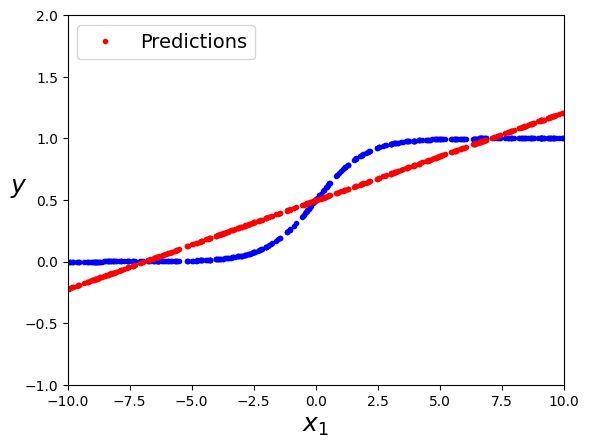

Noisy model


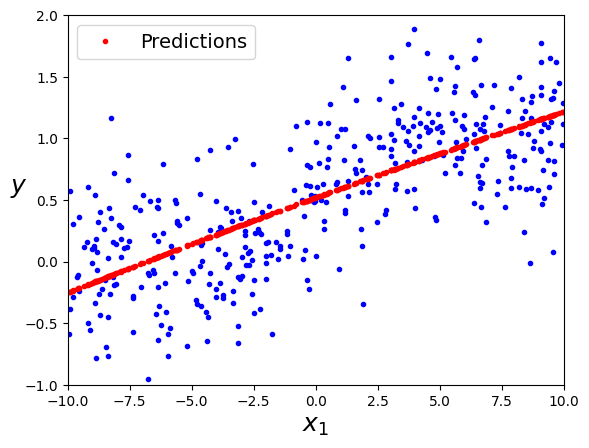

Number of polynomial features: 3
Clean model intercept: 0.4956756732739147
Clean model coefficient: [ 1.26760746e-01  1.03386954e-04 -9.00055533e-04]
Clean model training RMSE: 0.07438033095315996
Clean model testing RMSE: 0.08341903126182468
Noisy model intercept: 0.5191606605546144
Noisy model coefficient: [ 0.12644597 -0.0002445  -0.00086651]
Noisy model training RMSE: 0.4007100535192595
Noisy model testing RMSE: 0.4429131342902298
Clean model


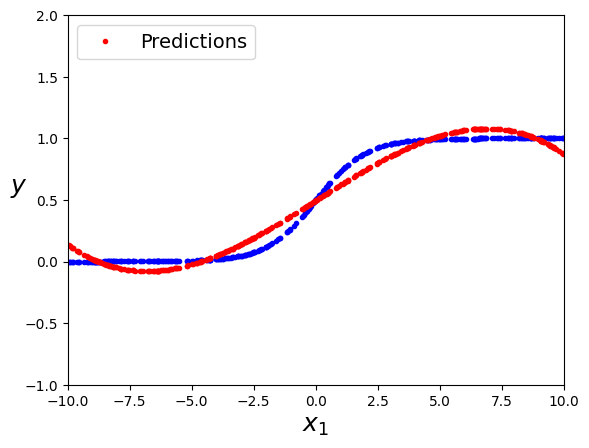

Noisy model


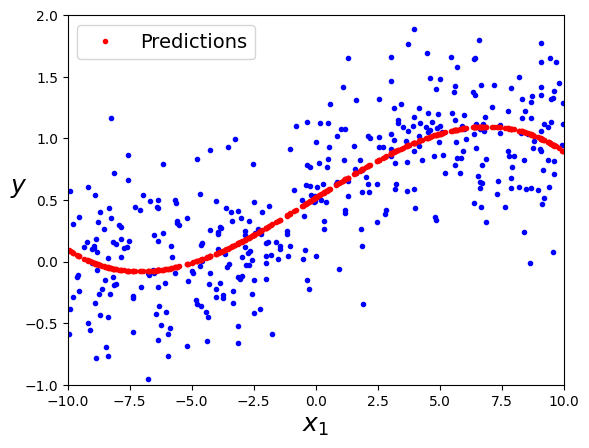

Number of polynomial features: 4
Clean model intercept: 0.4993020393683251
Clean model coefficient: [ 1.26826228e-01 -2.49161405e-04 -9.01357092e-04  4.05760663e-06]
Clean model training RMSE: 0.07431878404548754
Clean model testing RMSE: 0.08355796121554838
Noisy model intercept: 0.5105107751680633
Noisy model coefficient: [ 1.26289773e-01  5.96424258e-04 -8.63400966e-04 -9.67851324e-06]
Noisy model training RMSE: 0.4006450795979609
Noisy model testing RMSE: 0.4435987313798036
Clean model


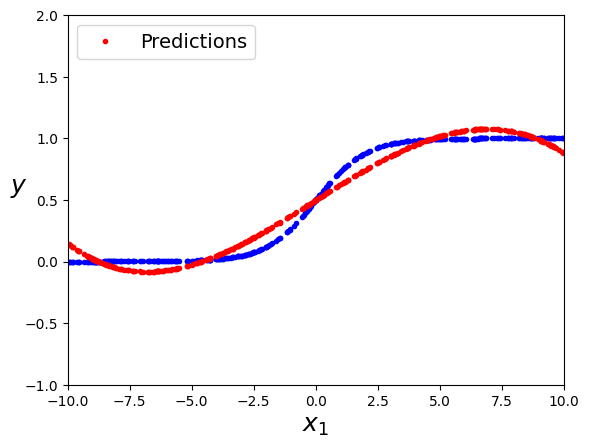

Noisy model


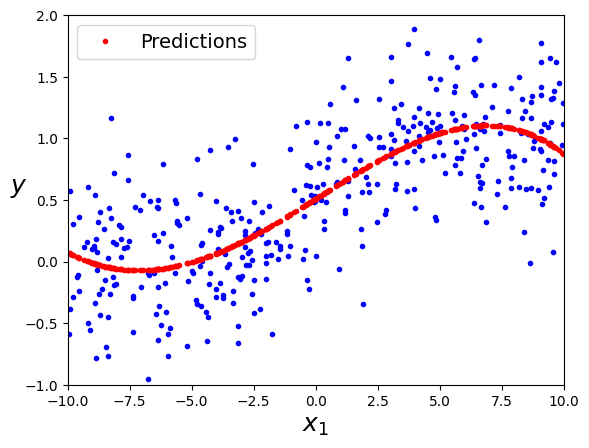

Number of polynomial features: 5
Clean model intercept: 0.5016232077150994
Clean model coefficient: [ 1.66096846e-01 -1.85310795e-04 -2.75879466e-03  1.76160550e-06
  1.68151833e-05]
Clean model training RMSE: 0.03866072555550046
Clean model testing RMSE: 0.04428889500933525
Noisy model intercept: 0.5139820080119186
Noisy model coefficient: [ 1.85017724e-01  6.91910798e-04 -3.64113930e-03 -1.31121093e-05
  2.51465676e-05]
Noisy model training RMSE: 0.389238923787811
Noisy model testing RMSE: 0.42911394840069966
Clean model


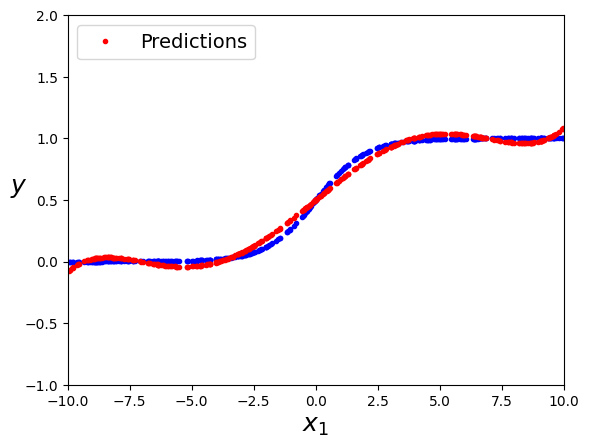

Noisy model


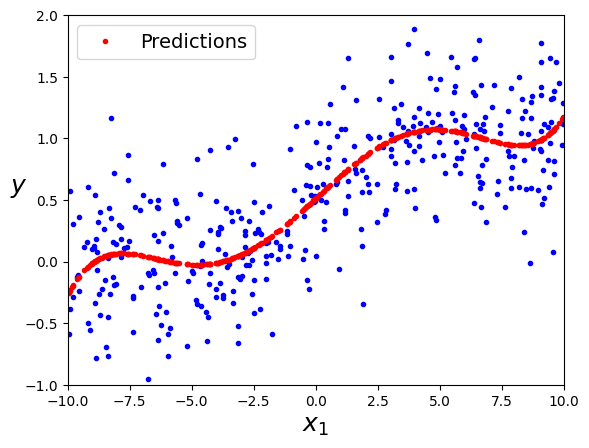

<Figure size 640x480 with 0 Axes>

In [15]:
for i in range(2, 6):
    print(f'Number of polynomial features: {i}')
    poly_features = PolynomialFeatures(degree = i, include_bias = False)
    x_poly = poly_features.fit_transform(x)
    train_eval(linear.Ridge(alpha = .01), x_poly)

We have reduces the RMSE of our noisy model slightly on the validation data, but it isn't leagues better.

Let's try a 20 degree model with LASSO.

Number of polynomial features: 20
Clean model intercept: 0.4966011469684213
Clean model coefficient: [ 8.42155594e-02  0.00000000e+00 -2.16394792e-04  5.64110455e-07
 -1.06602484e-06  2.48068746e-09 -3.52003107e-09 -6.66448649e-12
 -1.17820663e-11 -1.23179845e-13 -2.61177586e-14 -1.26130600e-15
  1.27194449e-16 -1.09379090e-17  2.90057285e-18 -8.57635786e-20
  3.49208332e-20 -6.17834954e-22  3.59229677e-22 -4.05058006e-24]
Clean model training RMSE: 0.1202785364761384
Clean model testing RMSE: 0.13486874515786815
Noisy model intercept: 0.511008476770735
Noisy model coefficient: [ 9.67367657e-02  0.00000000e+00  1.64036695e-03  4.39540791e-05
 -5.78119519e-05 -1.00045945e-06  1.56093600e-07 -7.92644272e-10
  2.12512694e-09  3.30319430e-11  1.23620244e-11  4.17145168e-13
  3.38631799e-14  3.19776955e-15 -2.50289457e-16  1.09228232e-17
 -5.31000333e-18 -1.60507677e-19 -5.85199057e-20 -4.47199933e-21]
Noisy model training RMSE: 0.3947973833472531
Noisy model testing RMSE: 0.454968632853937

c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.511e+01, tolerance: 1.462e+01
  model = cd_fast.enet_coordinate_descent(


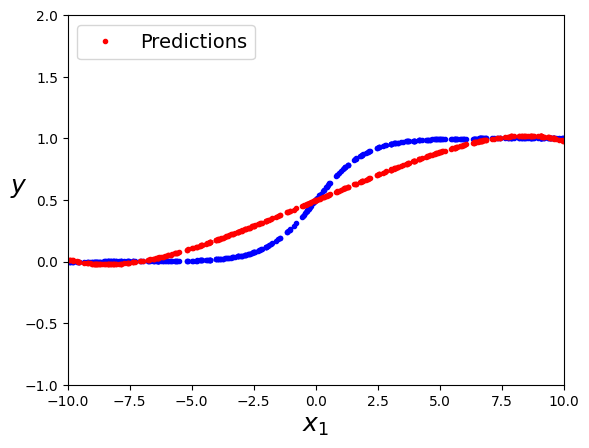

Noisy model


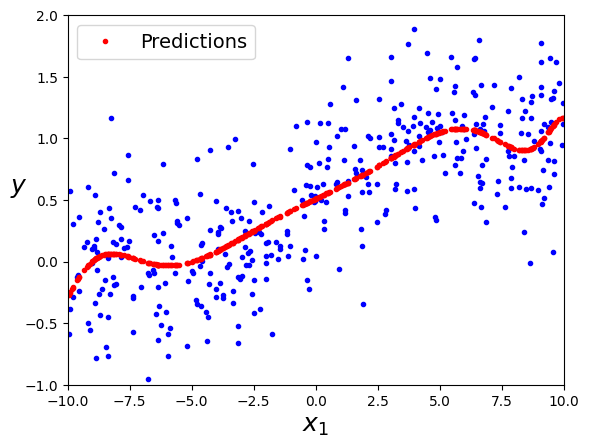

Clean


c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


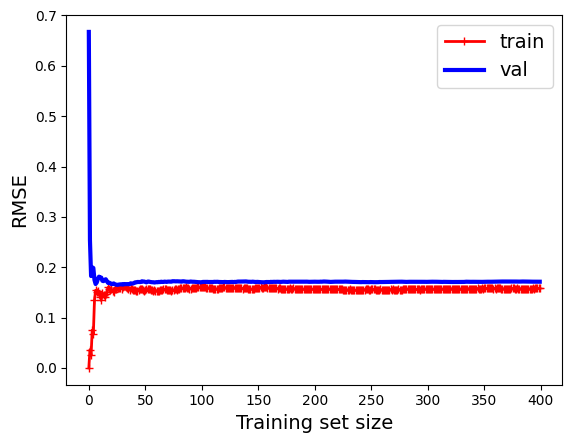

Noisy


c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 0.000e+00, tolerance: 0.000e+00
  model = cd_fast.enet_coordinate_descent(


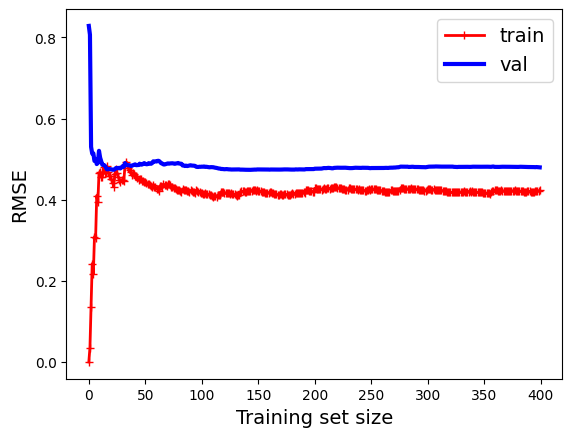

<Figure size 640x480 with 0 Axes>

In [16]:
print(f'Number of polynomial features: 20')
poly_features = PolynomialFeatures(degree = 20, include_bias = False)
x_poly = poly_features.fit_transform(x)
train_eval(linear.Lasso(alpha = .1, tol = .1), x_poly)

print("Clean")
plot_learning_curves(linear.Lasso(alpha = .1, tol = .1), x, y_clean)

print("Noisy")
plot_learning_curves(linear.Lasso(alpha = .1, tol = .1), x, y_noise)

While only one coefficient from each of the models ended up at 0, many of them are very close to 0.

SVR:

c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Clean model intercept: 0.47891980345158996
Clean model training RMSE: 0.3883285665526164
Clean model testing RMSE: 0.4000661023075187
Noisy model intercept: [0.5138121]
Noisy model training RMSE: 0.54913679861154
Noisy model testing RMSE: 0.6232615742431126
Clean model


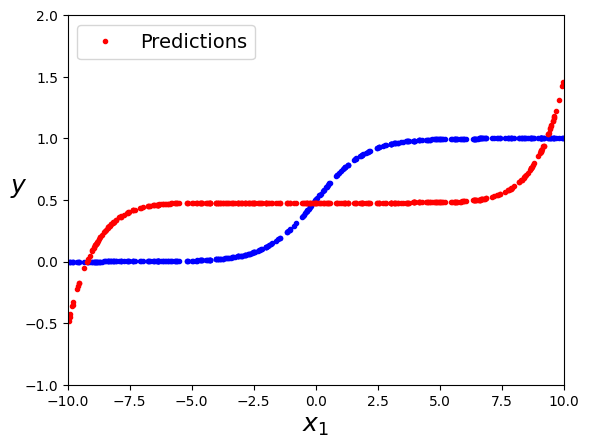

Noisy model


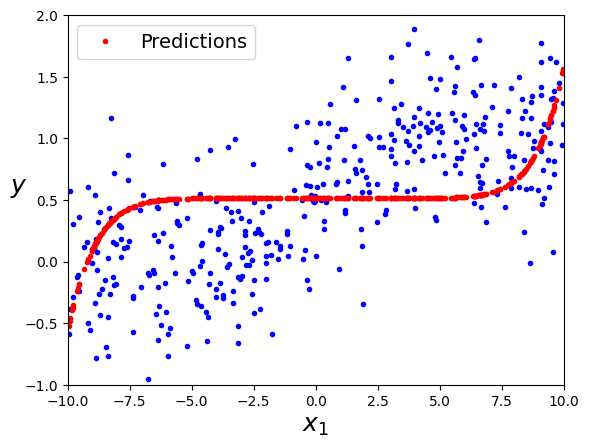

<Figure size 640x480 with 0 Axes>

In [17]:
train_eval(SVR(kernel = 'poly', degree= 9))

Pretty poor results using the polynomial kernel (a lot worse than the linear models), but a much better fit with the radial kernel.

Clean model intercept: 0.5004973554111192
Clean model training RMSE: 0.0548650804860004
Clean model testing RMSE: 0.059206206898863904
Noisy model intercept: [0.50691264]
Noisy model training RMSE: 0.3916415513270514
Noisy model testing RMSE: 0.4244939096354631
Clean model


c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


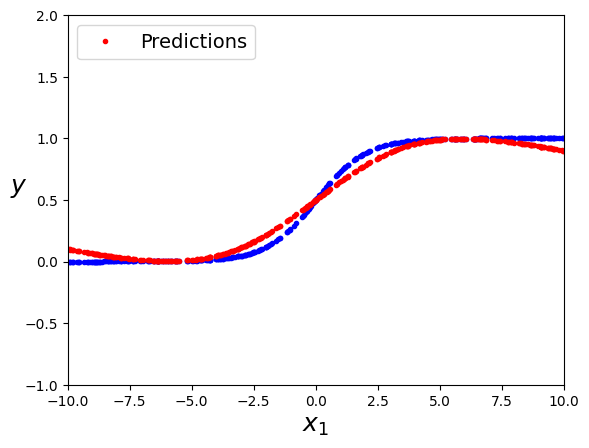

Noisy model


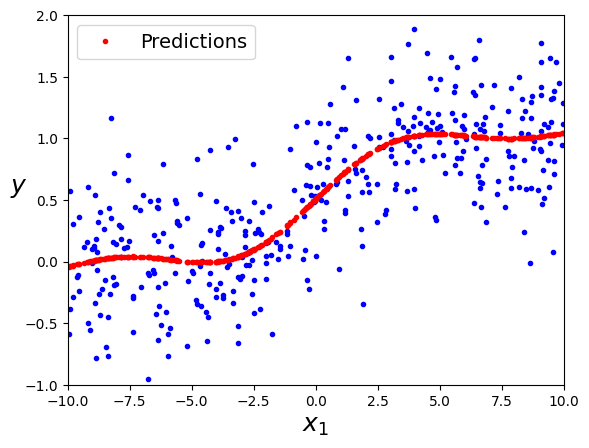

<Figure size 640x480 with 0 Axes>

In [18]:
train_eval(SVR(kernel = 'rbf'))

Pretty much the same model is fit either way, which is good. This model captures the true relationship almost perfectly.

Now let's try a Random Forest regressor.

c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Clean model training RMSE: 0.0007383695300860477
Clean model testing RMSE: 0.0030403210491591545
Noisy model training RMSE: 0.22689440081966494
Noisy model testing RMSE: 0.5018631840559712
Clean model


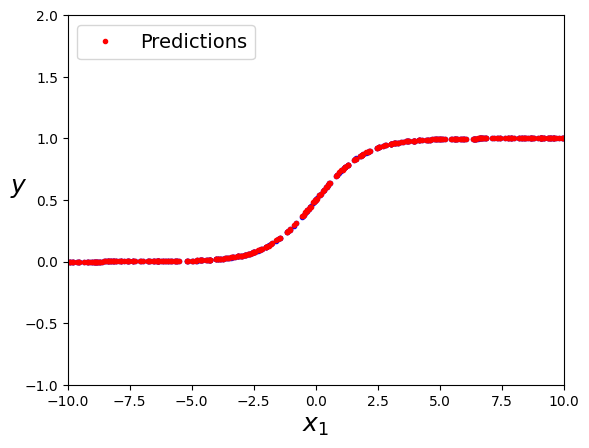

Noisy model


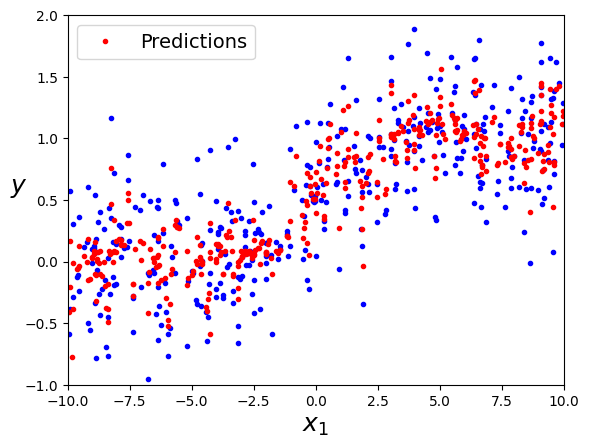

<Figure size 640x480 with 0 Axes>

In [19]:
train_eval(RandomForestRegressor(max_depth=10))

The Random Forest with depth of 10 overfits quite a lot when noise is introduced, but pretty much perfectly captures the relationship when there isn't noise.

Clean model training RMSE: 0.017659189841743264
Clean model testing RMSE: 0.02156665116210292
Noisy model training RMSE: 0.3739646886792894
Noisy model testing RMSE: 0.4398465000030388
Clean model


c:\Users\Nick\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


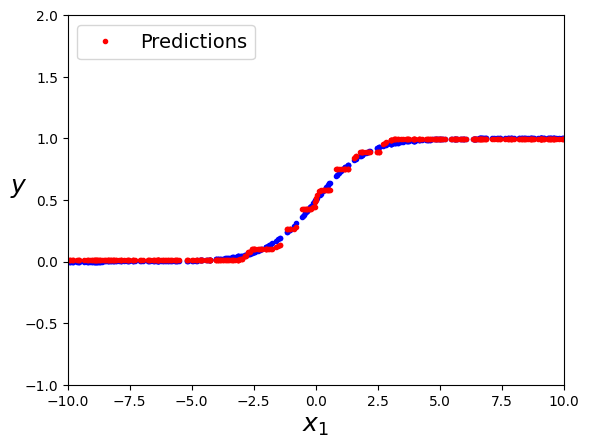

Noisy model


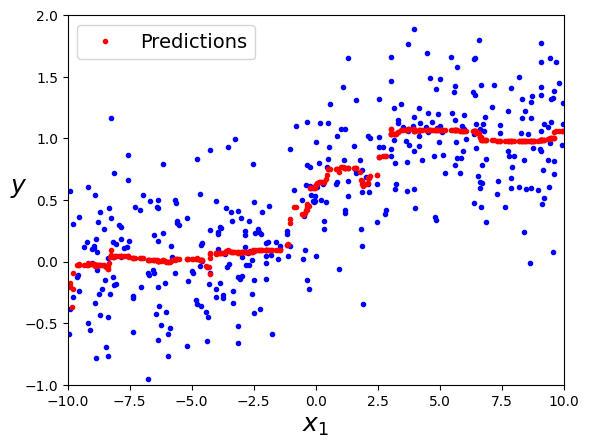

<Figure size 640x480 with 0 Axes>

In [20]:
train_eval(RandomForestRegressor(max_depth=3))

Depth of 3 limits the overfitting by quite a lot